# Base Imports

In [2]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [3]:
import toolz
from toolz import first

In [4]:
import pyrosetta.distributed

In [5]:
import tmol.tests.data

In [6]:
import tmol.system.io
import tmol.score
import torch

In [7]:
import numba
import numba.cuda
numba.config.NUMBA_NUM_THREADS = 10

In [8]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

from tmol.tests.benchmark import make_fixture, make_subfixture, stat_frame, subfixture

In [9]:
decoys = tmol.tests.data.structures_bysize()

In [10]:
from matplotlib import pyplot
import seaborn
import pandas

In [11]:
from numba import guvectorize
from numba import float32, float64
import math

import warnings
warnings.filterwarnings("ignore")

In [12]:
@numba.njit
def _lj_impl(a, b):
    delta = (a[0] - b[0],  a[1] - b[1], a[2] - b[2])

    d2 = delta[0] * delta[0] + delta[1] * delta[1] + delta[2] * delta[2]
    
    d6 = d2 * d2 * d2
    d12 = d6 * d6

    return d12 - 2 * d6    

def _lj_jit_kernel(a, b, out):
    for i in numba.prange(a.shape[0]):
        for j in numba.prange(b.shape[0]):
            out[i, j] = _lj_impl(a[i], b[j])
            
    return out

lj_jit_parallel = numba.njit(parallel=True)(_lj_jit_kernel)
lj_jit_serial = numba.njit(parallel=False)(_lj_jit_kernel)

@numba.cuda.jit
def _lj_cjit_kernel(a, b, out):
    i, j = numba.cuda.grid(2)
    if i < a.shape[0] and j < b.shape[1]:
        
        out[i, j] = _lj_impl(a[i], b[j])

In [13]:
def lj_naive(a, b):
    d2 = ((a - b) ** 2).sum(dim=-1)
    
    d6 = d2 * d2 * d2
    d12 = d6 * d6

    lj = (d12  - 2 * d6).sum()

    return float(lj)

In [14]:
import numpy

def benchmark_lj_runs(decoys):
    stats = []
    
    for n, d in decoys.items():
        fixture = make_fixture("lj", stats.append, nres=len(d.tmol_system.residues), natoms=len(d.tmol_coords), model=n)
        
        if fixture.extra_info["nres"] > 600:
            continue
        
        cpu_coords = d.tmol_coords.detach().to("cpu")
        cuda_coords = d.tmol_coords.detach().to("cuda")
        
        bs = (cuda_coords.shape[0],) * 2
        denorm_coords = cuda_coords.expand(bs + (3,)).clone()
        obuf = torch.empty(bs).to("cuda")
        
        n_denorm_coords = numba.cuda.as_cuda_array(denorm_coords)
        n_cuda_coords = numba.cuda.as_cuda_array(cuda_coords)
        n_obuf = numba.cuda.as_cuda_array(obuf)
            
        logging.info(f"{n} res: {len(d.tmol_system.residues)} atoms: {cpu_coords.shape}")
        
        @subfixture(fixture, device="cuda", impl="parallel_jit")
        def jit_cuda():
            out = torch.empty(cuda_coords.shape[:-1] * 2, device=cuda_coords.device)
            
            blocks_per_grid = ((cuda_coords.shape[0] // 32) + 1,) * 2
            threads_per_block = (32,) * 2
            
            _lj_cjit_kernel[blocks_per_grid, threads_per_block](cuda_coords, cuda_coords, out)
            
            return float(out.sum())
        
        @subfixture(fixture, device="cuda", impl="preorg_parallel_jit")
        def preorg_jit_cuda():
            blocks_per_grid = ((cuda_coords.shape[0] // 32) + 1,) * 2
            threads_per_block = (32,) * 2
            
            _lj_cjit_kernel[blocks_per_grid, threads_per_block](n_cuda_coords, n_cuda_coords, n_obuf)
            
            return float(obuf.sum())
        
        @subfixture(fixture, device="cpu", impl="parallel_jit")
        def jit_cpu():
            out = torch.empty(cpu_coords.shape[:-1] * 2)
            
            return float(lj_jit_parallel(cpu_coords.numpy(), cpu_coords.numpy(), out.numpy()).sum())
        
        @subfixture(fixture, device="cpu", impl="serial_jit")
        def jit_cpu_serial():
            out = torch.empty(cpu_coords.shape[:-1] * 2)
            
            return float(lj_jit_serial(cpu_coords.numpy(), cpu_coords.numpy(), out.numpy()).sum())
        
        @subfixture(fixture, device="cuda", impl="naive")
        def naive_cuda():
            a = cuda_coords[None, :, :]
            b = cuda_coords[:, None, :]
            
            lj_naive(a, b)
        
        @subfixture(fixture, device="cpu", impl="naive")
        def naive_cpu():
            a = cpu_coords[None, :, :]
            b = cpu_coords[:, None, :]
            
            return lj_naive(a, b)
        
    return stats

In [15]:
lj_res = benchmark_lj_runs(decoys)

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:levels all:warning'}
INFO:numba.cuda.cudadrv.driver:init
INFO:root:BYSIZE_400_RES_6AZU res: 370 atoms: torch.Size([7176, 3])
INFO:root:BYSIZE_200_RES_5MM8 res: 197 atoms: torch.Size([3600, 3])
INFO:root:BYSIZE_250_RES_5N5G res: 233 atoms: torch.Size([4128, 3])
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:root:BYSIZE_300_RES_6F8B res: 298 atoms: torch.Size([5408, 3])
INFO:root:BYSIZE_100_RES_5UMR res: 97 atoms: torch.Size([1864, 3])
INFO:root:BYSIZE_055_RES_2JWU res: 56 atoms: torch.Size([1080, 3])
INFO:root:BYSIZE_500_RES_5V2D res: 488 atoms: torch.Size([9136, 3])
INFO:root:BYSIZE_040_RES_5UOI res: 43 atoms: torch.Size([816, 3])
INFO:tmol.system.io.ResidueReader:missing at

In [16]:
dat = stat_frame(lj_res)

dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'lj.jit_cpu_serial'").groupby("nres").time.mean().rename("serial_cpu_mean").to_frame(),
            left_on="nres",
            right_index=True
        ).eval("time / serial_cpu_mean").rename("serial_cpu_relative")
    ),
    axis=1
)

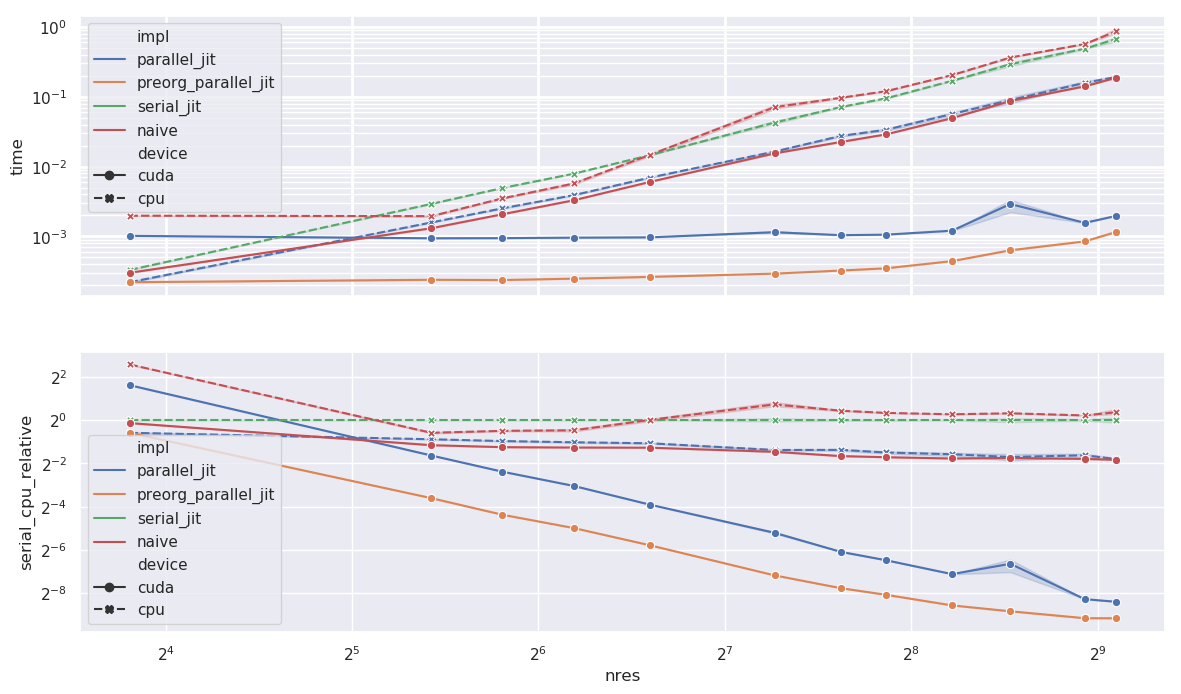

In [17]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="impl", style="device", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "serial_cpu_relative", data=dat, hue="impl", style="device", markers=True)